<a href="https://colab.research.google.com/github/kinzinzz/Analysis_of_Fine_Dust/blob/master/CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import os 
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [7]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 12), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), 9.65 KiB | 658.00 KiB/s, done.
Downloading...
From: https://drive.google.com/uc?id=1B36Djko-f0LtVxSaBEVYosLTTsu0qtsh
To: /content/COVIDTimeSeries.zip
100% 3.18M/3.18M [00:00<00:00, 177MB/s]
COVIDTimeSeries.zip download complete!


In [8]:
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,47851,48053,48116,48229,48527,48718,48952,49161,49378,49621
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,45188,46061,46863,47742,48530,49191,50000,50637,51424,52004
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,90014,90579,91121,91638,92102,92597,93065,93507,93933,94371
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,7162,7190,7236,7288,7338,7382,7382,7446,7466,7519
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,15804,15925,16061,16161,16188,16277,16362,16407,16484,16562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,1381,1385,1391,1395,1397,1402,1405,1405,1407,1410
267,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,102992,104879,106622,108099,109738,111102,113409,115606,117755,119612
268,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2079,2081,2082,2083,2083,2084,2085,2085,2087,2087
269,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,18062,18091,18161,18217,18274,18322,18428,18456,18504,18575


In [9]:
confirmed[confirmed['Country/Region']=='Korea, South']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
157,NaN,"Korea, South",35.907757,127.766922,1,1,2,2,3,4,...,40098,40786,41736,42766,43484,44364,45442,46453,47515,48570


In [15]:
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')
daily_cases

,157
2020-01-22,1
2020-01-23,0
2020-01-24,1
2020-01-25,0
2020-01-26,1
...,...
2020-12-14,880
2020-12-15,1078
2020-12-16,1011
2020-12-17,1062


In [20]:
# 데이터 전처리
def create_sequence(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequence(daily_cases, seq_length)

# 학습용, 검증용, 시험용으로 분리
train_size = int((len(daily_cases)-seq_length)*0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

# 스케일링
MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

  return (array - min) / (max - min)

X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

# Tensor transform
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

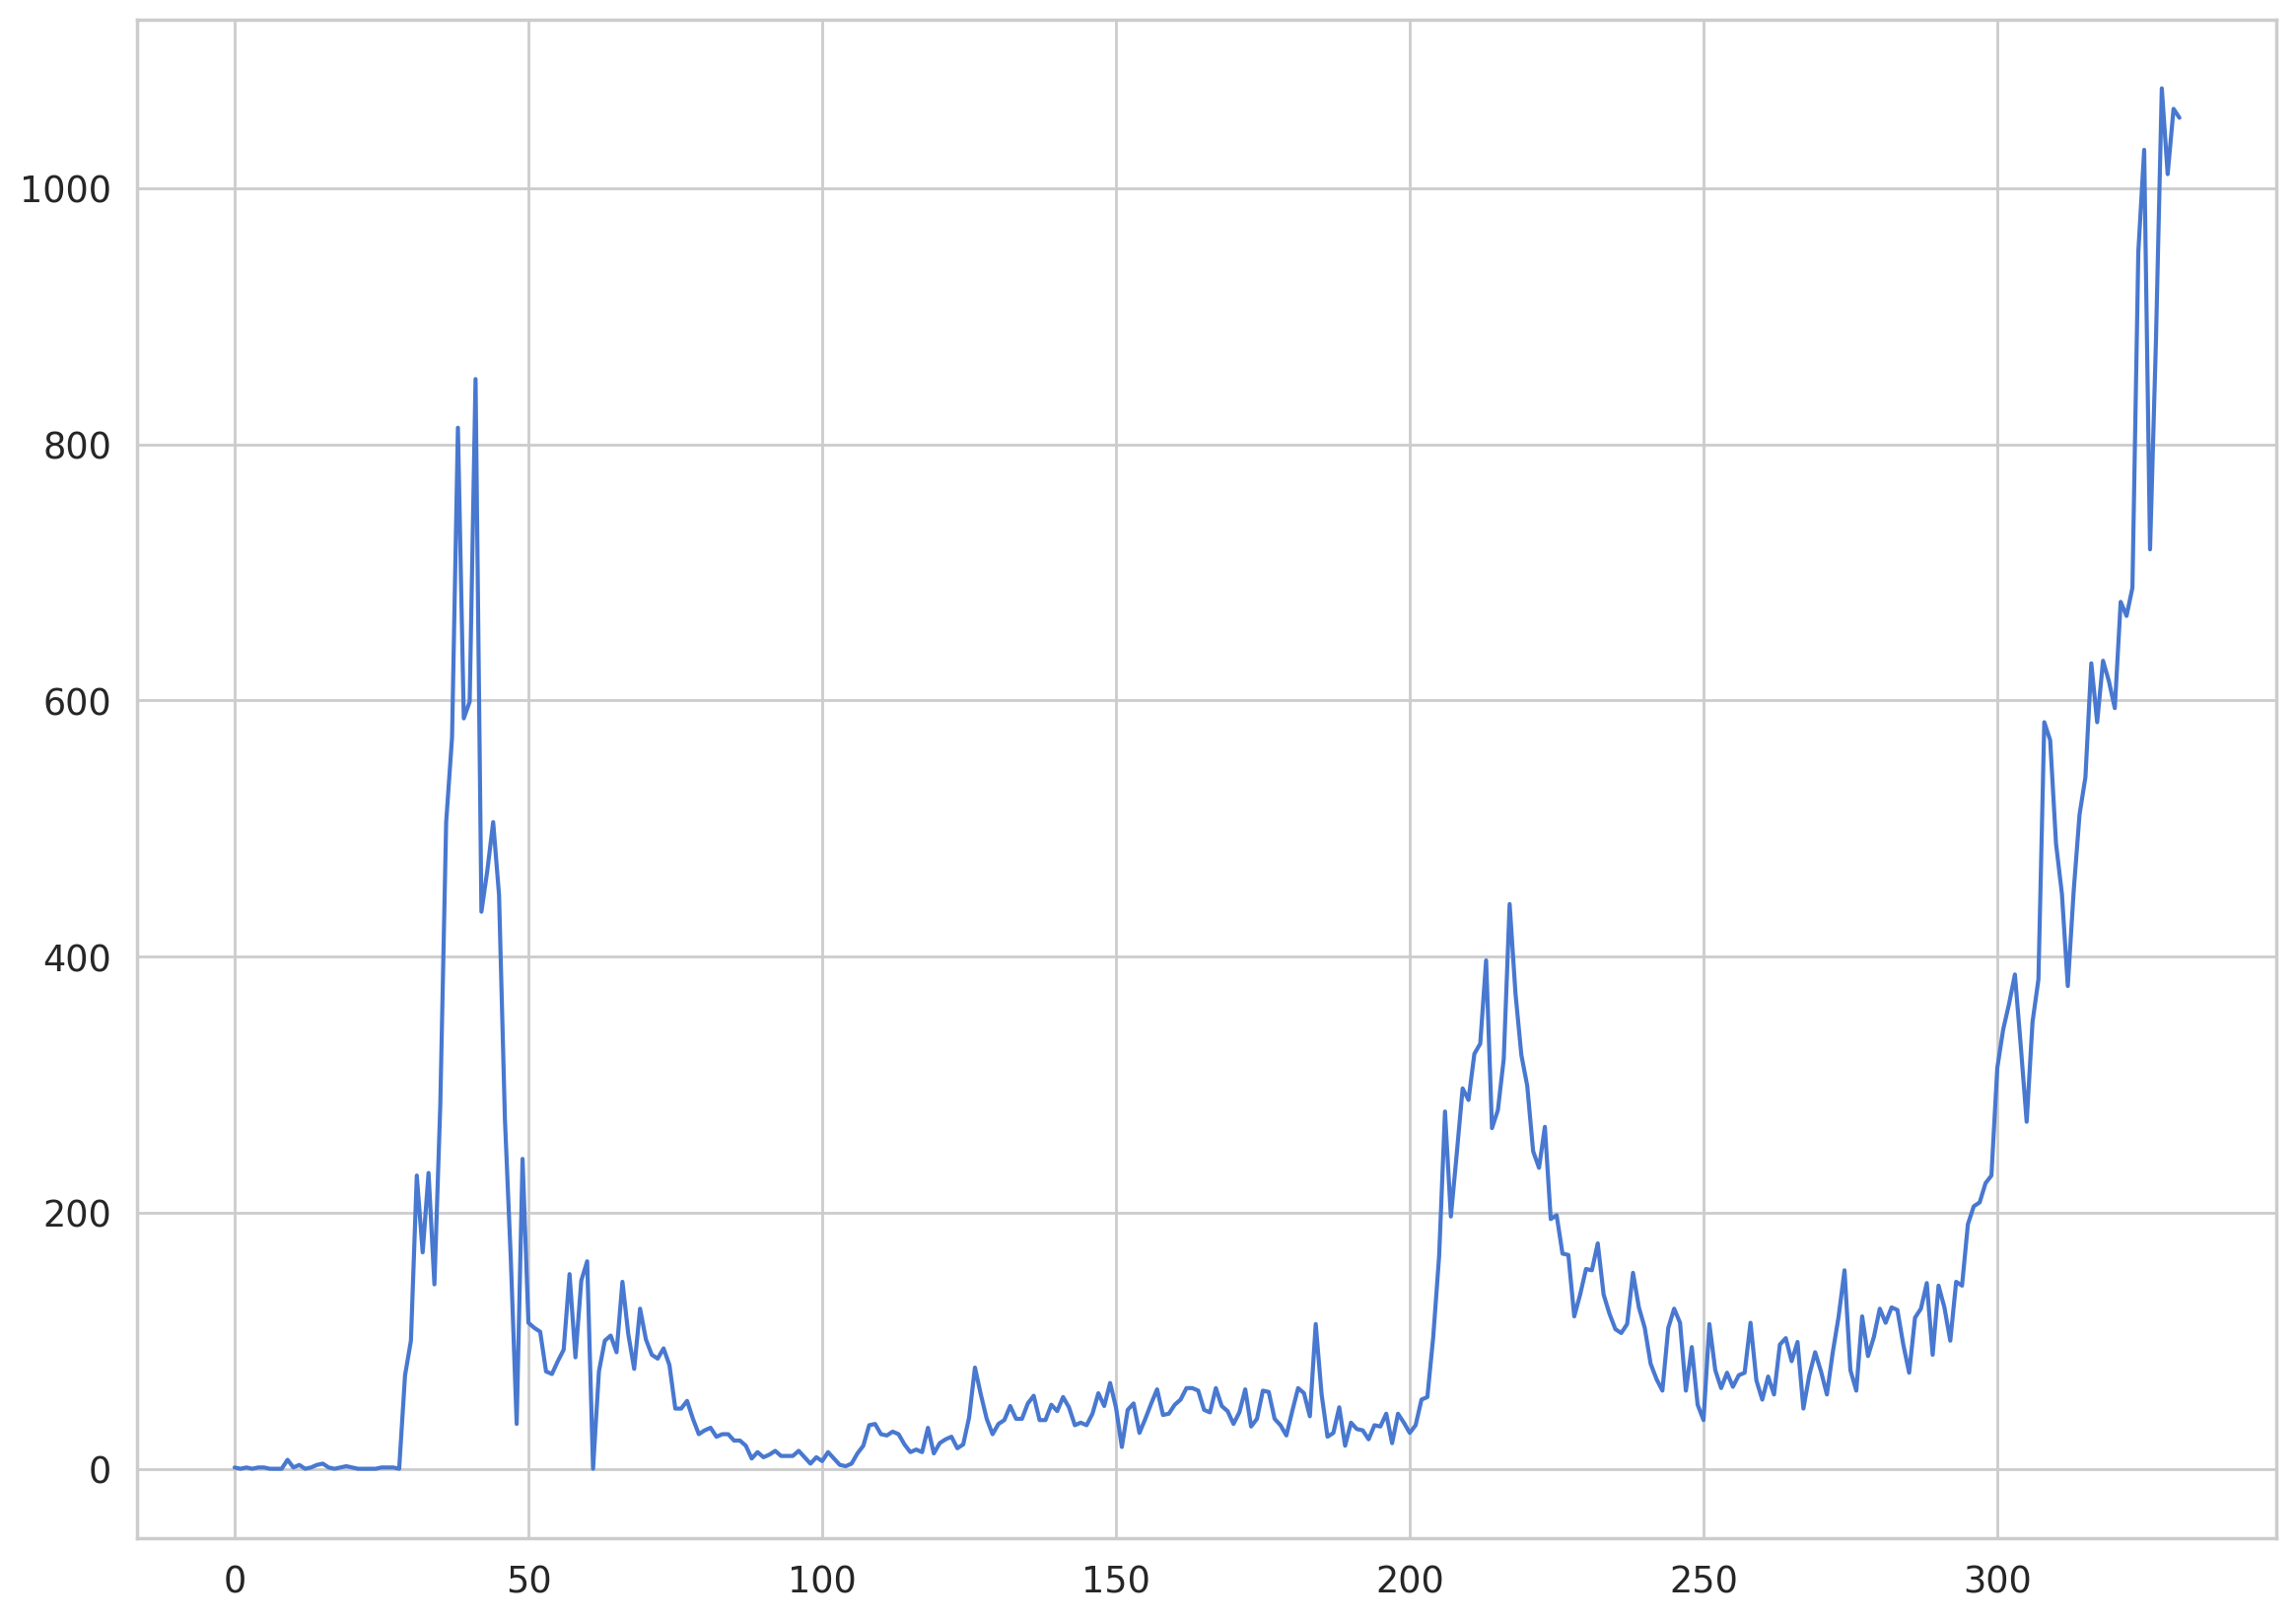

In [21]:
plt.plot(daily_cases.values)

In [22]:
# 1D CNN Example
c = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
input = torch.Tensor([[[1,2,3,4,5]]])
output = c(input)
output

tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<ConvolutionBackward0>)

In [23]:
for param in c.parameters(): 
    print(param)

Parameter containing:
tensor([[[0.5406, 0.5869]]], requires_grad=True)
Parameter containing:
tensor([-0.1657], requires_grad=True)


In [26]:
w_list = []
for param in c.parameters():
    w_list.append(param)

w = w_list[0]
b = w_list[1]

w1 = w[0][0][0]
w2 = w[0][0][1]

print(w1, w2, b)

Parameter containing:
tensor([[[0.5406, 0.5869]]], requires_grad=True)
tensor(0.5406, grad_fn=<SelectBackward0>) tensor(0.5869, grad_fn=<SelectBackward0>) Parameter containing:
tensor([-0.1657], requires_grad=True)


In [29]:
w1 * 4 + w2 * 5 + b

tensor([4.9313], grad_fn=<AddBackward0>)

In [28]:
output

tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<ConvolutionBackward0>)

In [55]:
# definition of model
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [56]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): # sample 별 hidden state reset을 해줘야 함 

            model.reset_hidden_state()

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() #seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [57]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

In [58]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.08784928810836255 val loss: 0.046221233904361725
Epoch 10 train loss: 0.03539680937033903 val loss: 0.03601609542965889
Epoch 20 train loss: 0.03316489942603784 val loss: 0.033923257142305374
Epoch 30 train loss: 0.03315280139681765 val loss: 0.03661714121699333
Epoch 40 train loss: 0.03310268853837446 val loss: 0.03512498363852501
Epoch 50 train loss: 0.03295596727969346 val loss: 0.03514387086033821
Epoch 60 train loss: 0.03308349452249106 val loss: 0.034864265471696854
Epoch 70 train loss: 0.03258869972461799 val loss: 0.03687545657157898
Epoch 80 train loss: 0.03260931548380589 val loss: 0.03492854908108711
Epoch 90 train loss: 0.03281696275112101 val loss: 0.03836681693792343


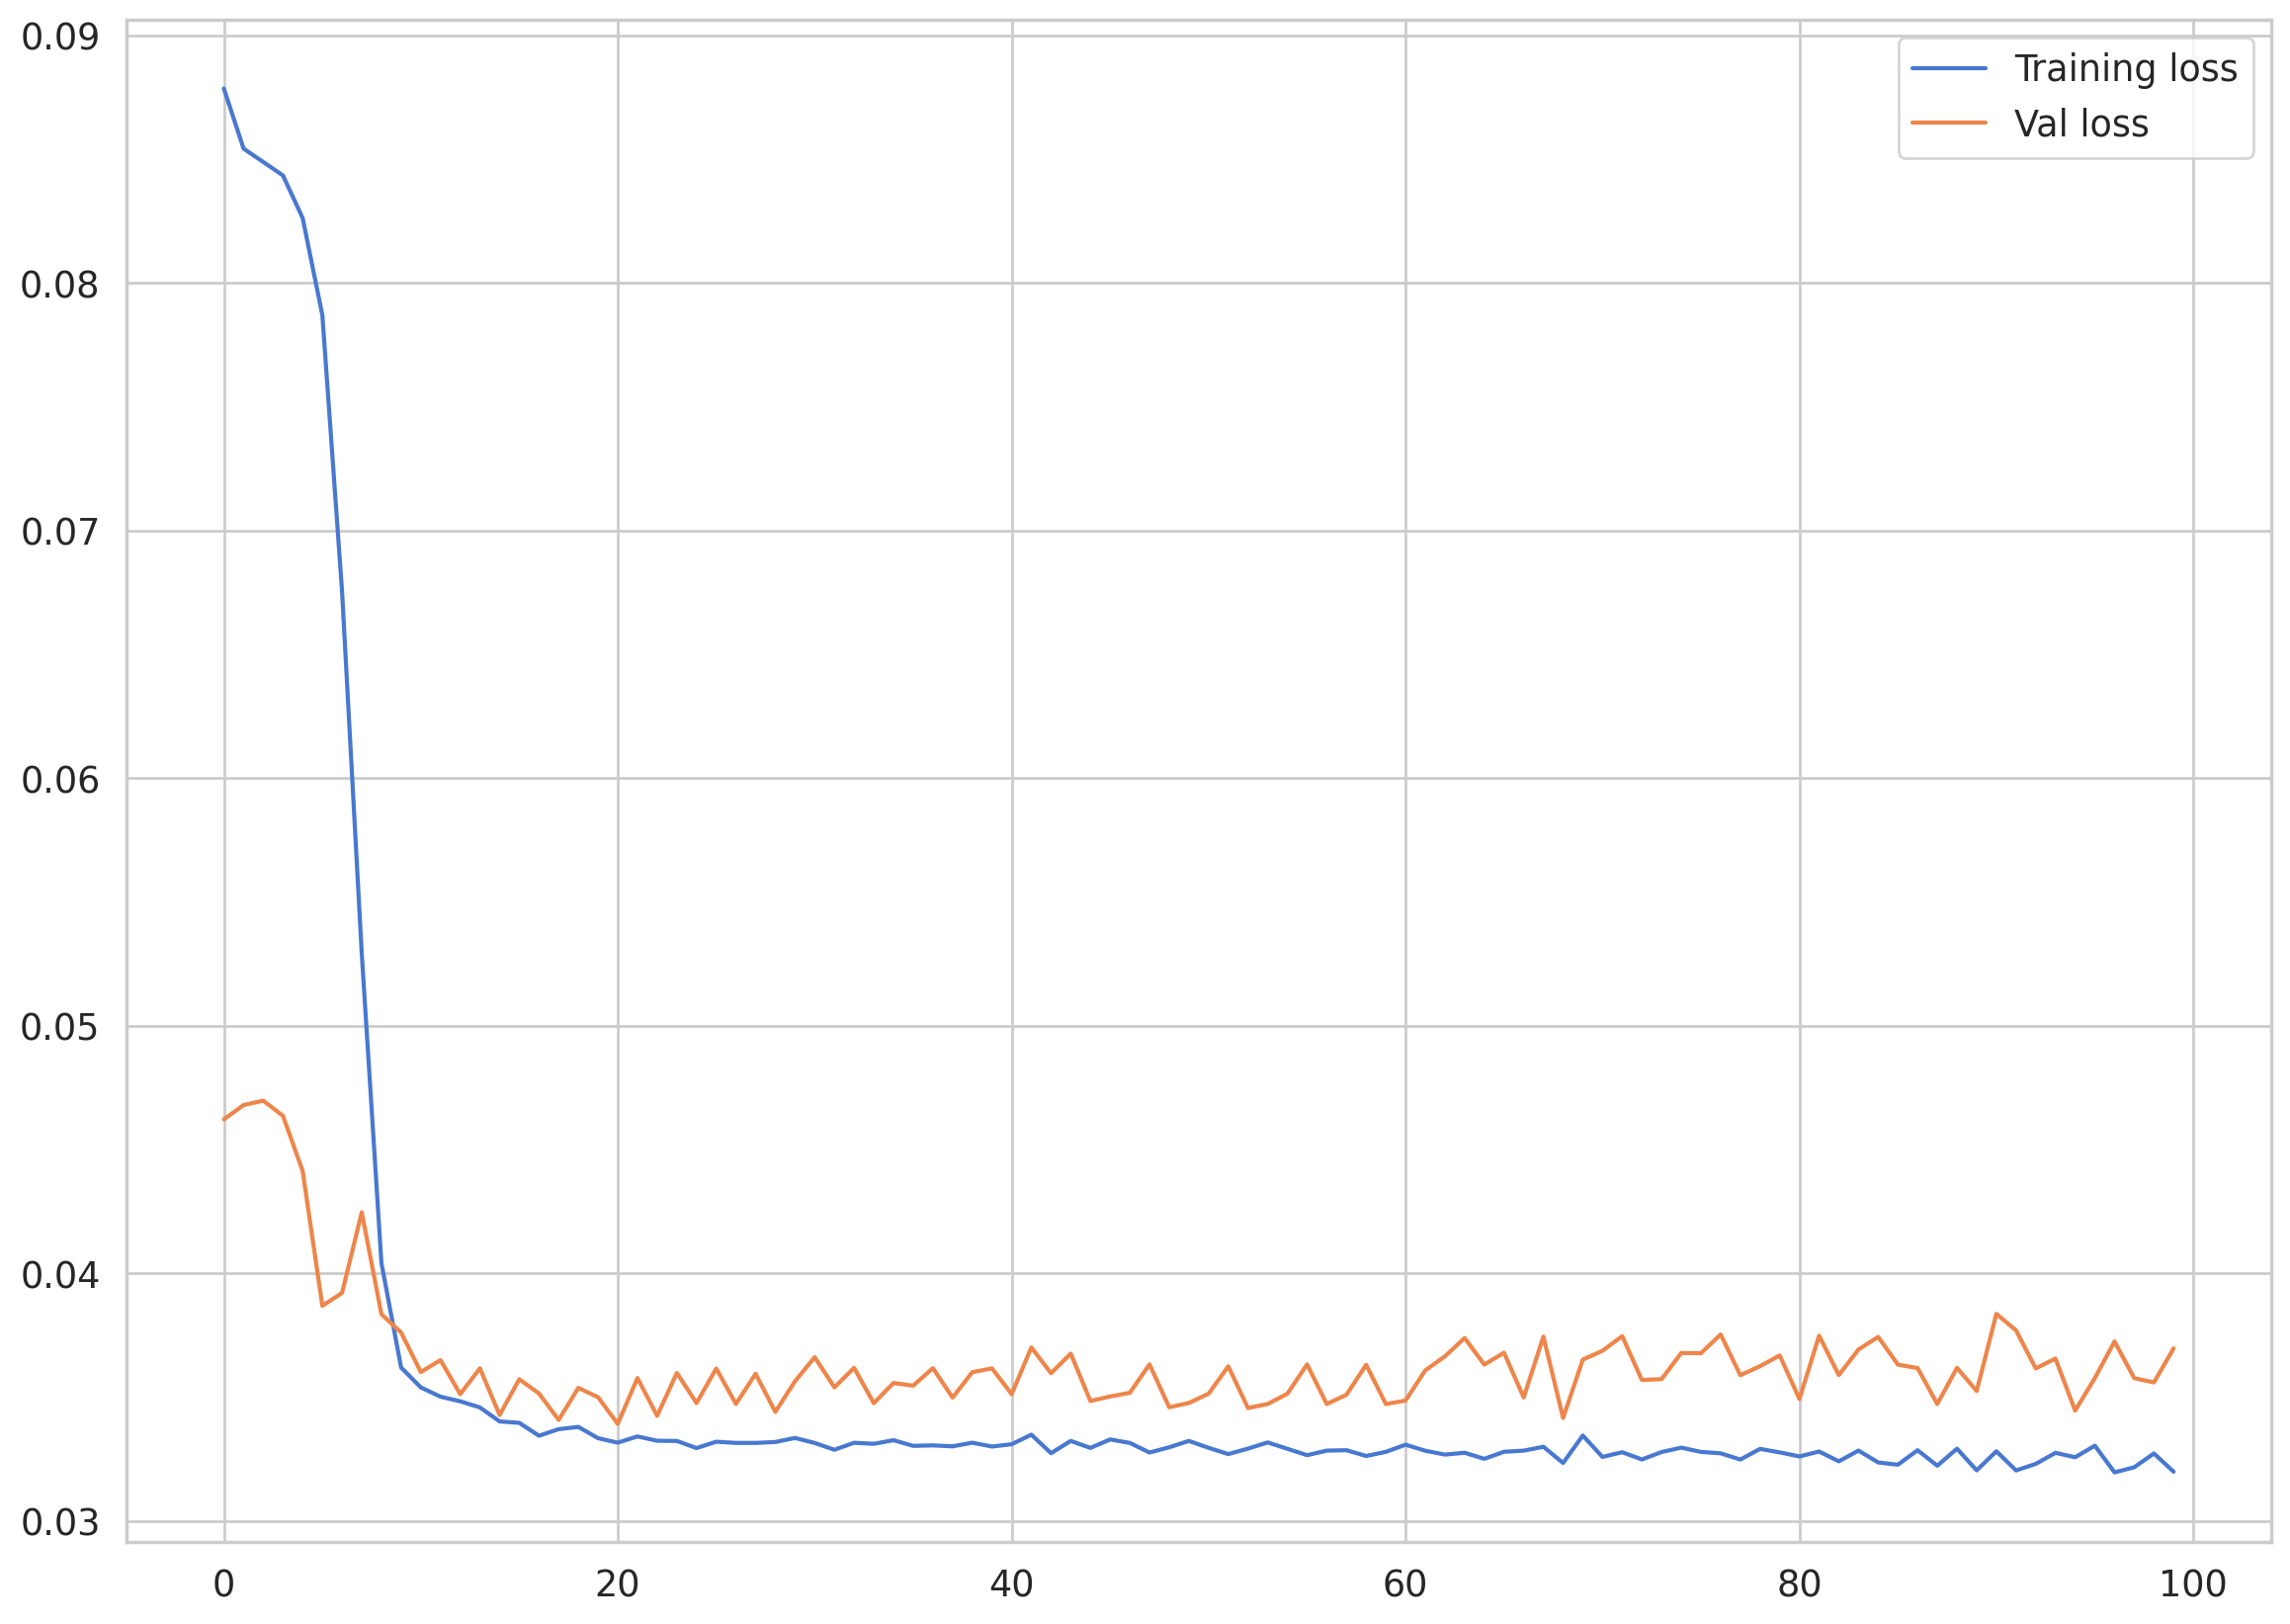

In [59]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [60]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

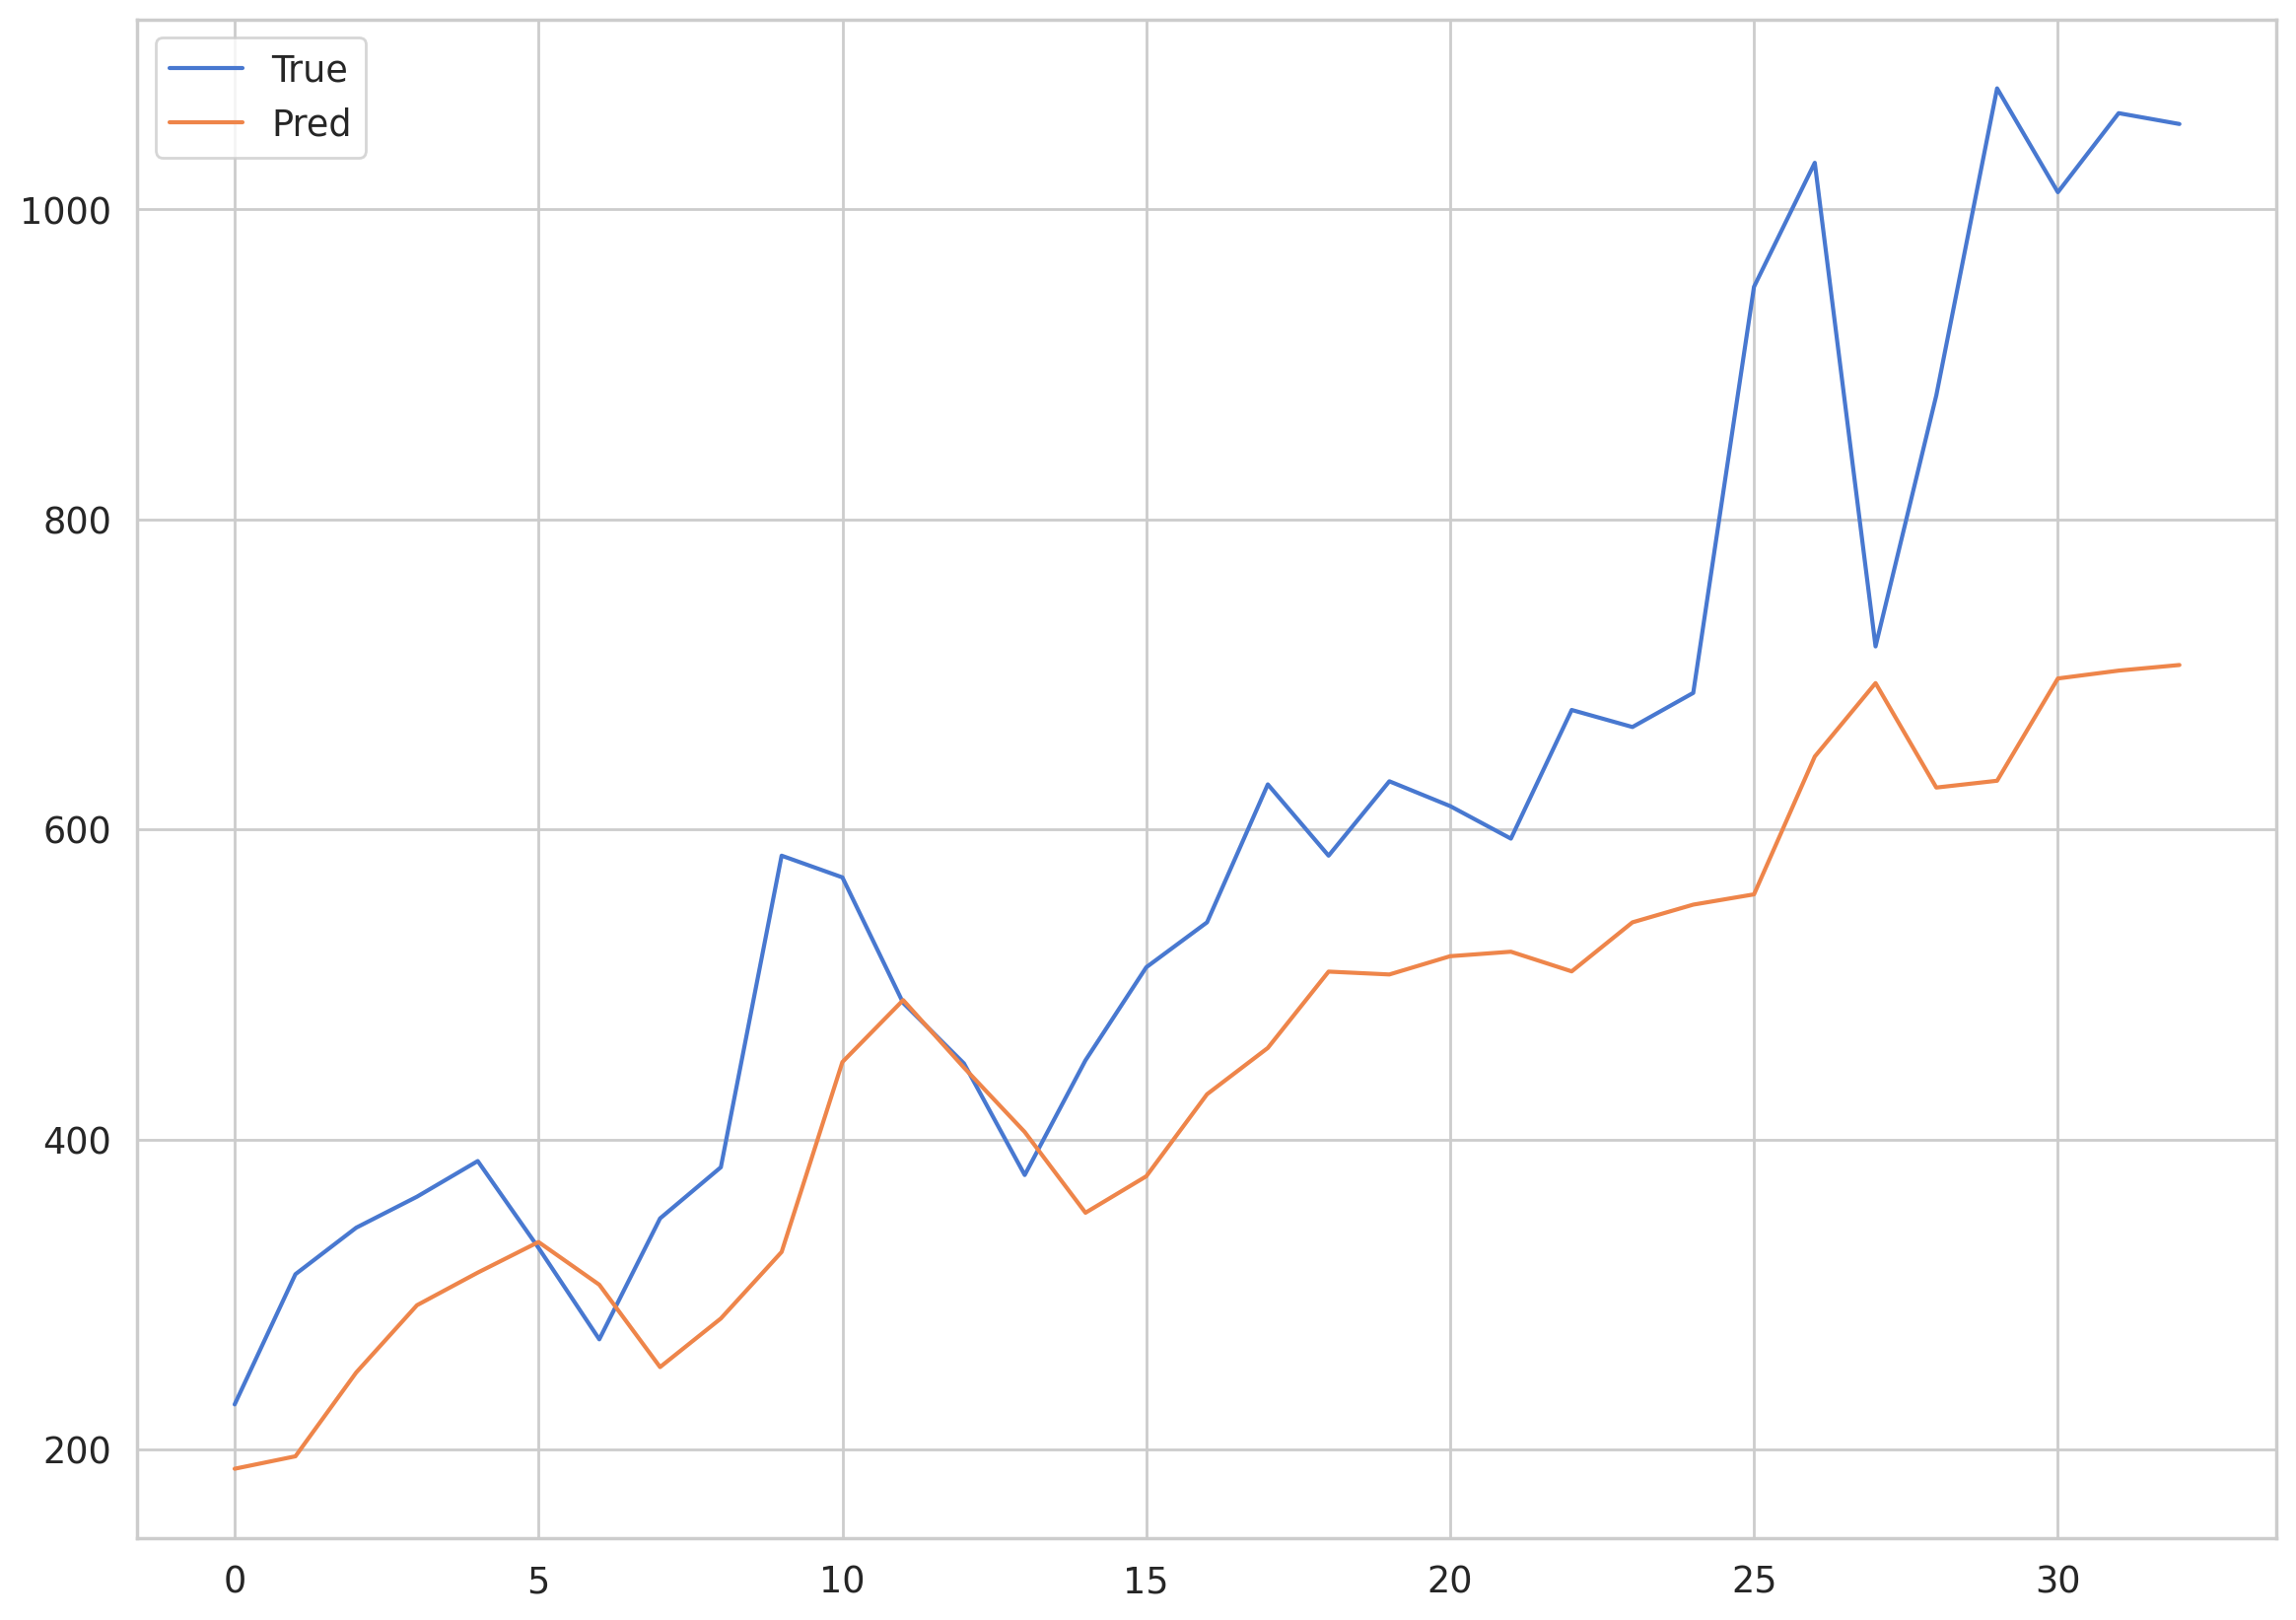

In [61]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [62]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

252.32018386395401